We changed the normalization funtction a little bit for later use 

In [ ]:
samplingFrequency = 500
def normalize(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    data = (data - mean) / std
    return data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/2390_Qi_Tian/2390--Spring2022/Week03/*.mat /content/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


First we download the files from the kaggle. There are two zip files of training set and test set. In the training set there are 12 human subjects. Each subject has performed 8 series, producing 16 excel files. Eight of them are the sampled EEG data and the other half is the corresponding labels. We can examine one series from one subject and it is representative of the other.      

# Let's examine one series of one subject

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

The dataframe has around 120000 rows. According to the data description, the sampling rate is 500Hz. So each series lasts for about 240s. Sensors sample every 2 ms. 

In [ ]:
sub1_s1_data = pd.read_csv('/content/gdrive/MyDrive/2390_Qi_Tian/subj1_series1_data.csv')
print(sub1_s1_data.shape)
sub1_s1_events = pd.read_csv('/content/gdrive/MyDrive/2390_Qi_Tian/subj1_series1_events.csv')
print(sub1_s1_events.shape)



(119496, 33)
(119496, 7)


# Plot EEG signals, spectrogram  from one channel P1. 

Text(0, 0.5, 'Density')

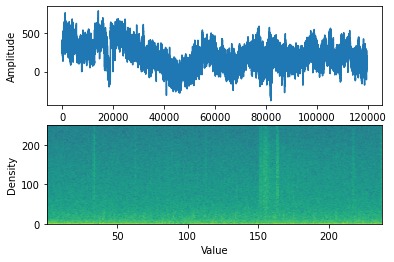

In [ ]:
plot.subplot(211)
plot.plot(sub1_s1_data.P3)
plot.xlabel('Sample')
plot.ylabel('Amplitude')


plot.subplot(212)
plot.specgram(sub1_s1_data.P3, Fs=samplingFrequency,NFFT=samplingFrequency*2, noverlap=(samplingFrequency))
plot.xlabel('Value')
plot.ylabel('Density')

Each data file has 33 columns, 1 index column and 32 channels of raw EEG data.

Each events file has 7 columns, 1 index column and 6 event columns. The event label columns are either zero or one depending on whether corresponding event happens. 

In [ ]:
print(sub1_s1_data.columns)
print(sub1_s1_events.columns)

Index(['id', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2',
       'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6',
       'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10'],
      dtype='object')
Index(['id', 'HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased'],
      dtype='object')


# Use df.head() to have a understanding of how the training and test datasets look like.

In [ ]:
sub1_s1_data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


In [ ]:
sub1_s1_events.head()

,id,HandStart,FirstDigitTouch,BothStartLoadPhase,LiftOff,Replace,BothReleased
0,subj1_series1_0,0,0,0,0,0,0
1,subj1_series1_1,0,0,0,0,0,0
2,subj1_series1_2,0,0,0,0,0,0
3,subj1_series1_3,0,0,0,0,0,0
4,subj1_series1_4,0,0,0,0,0,0


In [ ]:
sub1_s1_events.drop('id', axis=1).sum(axis=0)

HandStart             5100
FirstDigitTouch       5100
BothStartLoadPhase    5100
LiftOff               5100
Replace               5100
BothReleased          5100
dtype: int64

# Use groupby() and count() to generate the table below. From this table we can derive following information: 

*   There are much more non event samples than event samples.
*   Size varies between different events. For instance, HandStart event has 5100 samples while BothReleased has 3748 samples. This is due to the fact that some events happen at the same time.
*   Multiple events might occur at the same time.







In [ ]:
sub1_s1_events.drop('id', axis=1).groupby(['HandStart','FirstDigitTouch','BothStartLoadPhase','LiftOff','Replace','BothReleased']).size()

HandStart  FirstDigitTouch  BothStartLoadPhase  LiftOff  Replace  BothReleased
0          0                0                   0        0        0               96451
                                                                  1                3748
                                                         1        0                3748
                                                                  1                1352
                                                1        0        0                3153
                            1                   0        0        0                 343
                                                1        0        0                 501
           1                0                   0        0        0                 844
                            1                   0        0        0                2810
                                                1        0        0                1446
1          0                0            

In [ ]:
sub1_s1_data = sub1_s1_data.drop(columns = ['id'])

# Computed the mean and std along all the channels

In [ ]:
print(sub1_s1_data.mean(axis=0))
print(sub1_s1_data.std(axis=0))

Fp1     265.934374
Fp2     404.173194
F7      398.503774
F3      215.615385
Fz      144.392189
F4      443.437395
F8     -122.864221
FC5     474.953538
FC1      88.350681
FC2      16.658583
FC6     325.775624
T7      -72.496017
C3      164.679822
Cz        8.043031
C4      297.241439
T8      296.862715
TP9     144.547608
CP5      -0.888189
CP1     112.011406
CP2     234.946877
CP6      27.035206
TP10     85.143754
P7      450.076714
P3      211.734401
Pz      188.356271
P4      162.037800
P8      368.885569
PO9     102.616556
O1      305.008302
Oz       28.207438
O2       67.214919
PO10    155.612497
dtype: float64
Fp1      373.911366
Fp2      313.686274
F7       207.645572
F3       204.065055
Fz       141.130921
F4       221.457186
F8       479.160803
FC5      198.874064
FC1      113.654894
FC2      124.604345
FC6      317.959455
T7       654.323615
C3       160.777132
Cz       104.530898
C4       141.144494
T8      1281.825049
TP9     1166.903290
CP5      158.022883
CP1      159.5641

# Plot histogram to see the mean distribution of 16 channels.

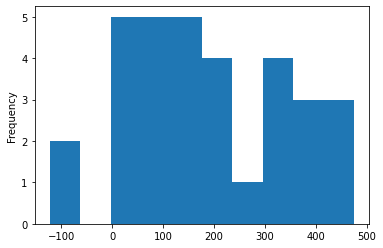

In [ ]:
sub1_s1_data.mean(axis=0).plot.hist()

# Plot histogram to see the std distribution of 16 channels.

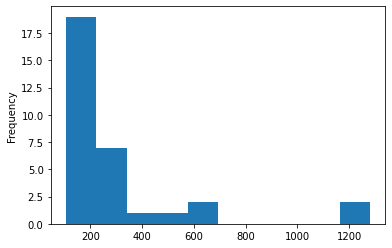

In [ ]:
sub1_s1_data.std(axis=0).plot.hist()

# Plot histograms for all 32 channels.

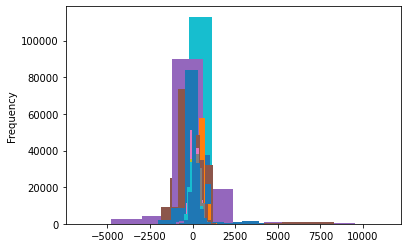

In [ ]:
for i in sub1_s1_data.columns[1:]:
  sub1_s1_data[i].plot.hist()

In [ ]:
normalized = normalize(sub1_s1_data)